<a href="https://colab.research.google.com/github/dante3112/NetworkAnalysis/blob/master/Routing%26Animation_OSMNx_Dharamshala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
 
import matplotlib.pyplot as plt
import plotly_express as px

import requests 
import networkx as nx
import osmnx as ox
import matplotlib.colors as colors
import matplotlib.cm as cm
import folium
from IPython.display import IFrame
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.14.0'

In [0]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

/usr/local/lib/python3.6/dist-packages/osmnx/projection.py:62: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



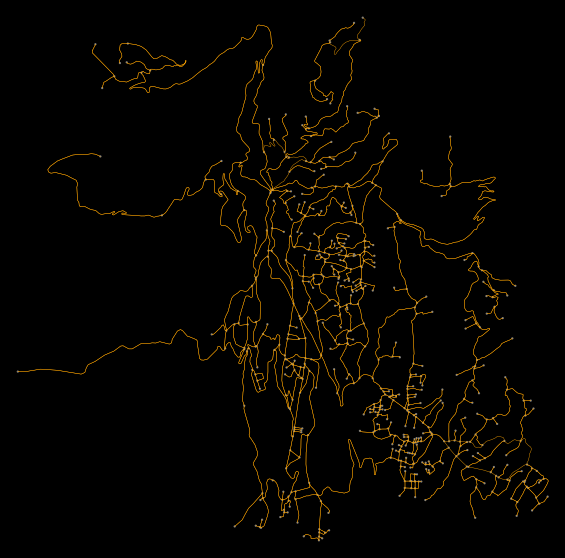

(<Figure size 863.499x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe6aa6b3320>)

In [4]:
G = create_graph("Dharamshala", 2500, "drive")
ox.plot_graph(G, fig_height=10, node_size=5, bgcolor='k', edge_color='orange', edge_linewidth=0.4, node_color='grey')

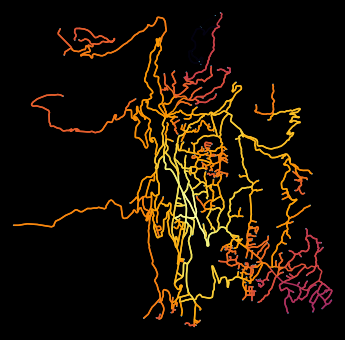

In [5]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
#closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. 
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

# ROUTING

In [0]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [0]:
# impute missing edge speeds and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [0]:
start = (32.213813, 76.320668)
end1 = (32.220054, 76.316225)
end2 = (32.206864, 76.323984)

start_node = ox.get_nearest_node(G, start) 
end_node1 = ox.get_nearest_node(G, end1)
end_node2 = ox.get_nearest_node(G, end2)

route1 = nx.shortest_path(G, start_node, end_node1, weight='travel_time')
route2 = nx.shortest_path(G, start_node, end_node2, weight='travel_time')

#route color
rc1 = ['r'] * (len(route1) - 1)
rc2 = ['b'] * len(route2)
rc = rc1 + rc2
nc = ['r', 'r', 'b', 'b']
    


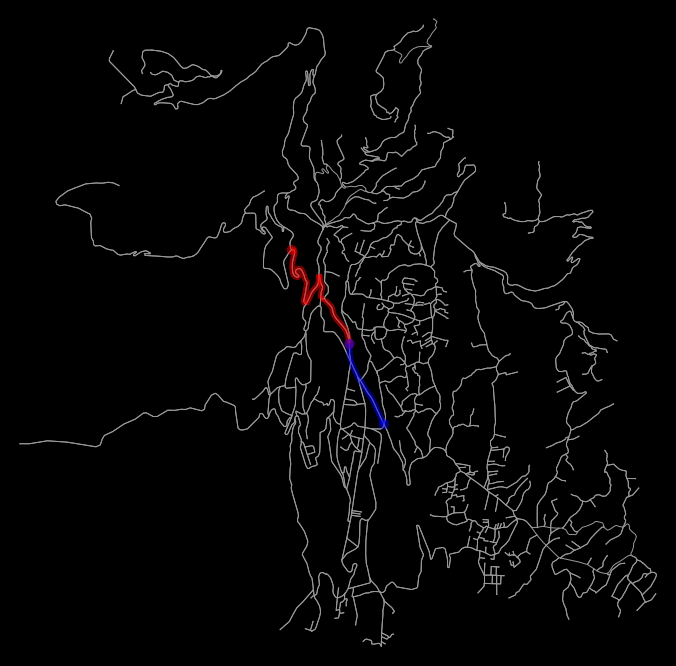

In [9]:
mm = ox.plot_graph_routes(G, [route1, route2], route_color=rc, orig_dest_node_color=nc, node_size=2, bgcolor='k',fig_width=12, fig_height=12, route_linewidth=6)

In [10]:
# riute length in meters
edge_length1 = ox.utils_graph.get_route_edge_attributes(G, route1, 'length')
sum(edge_length1)

1528.6469999999995

In [11]:
edge_length2 = ox.utils_graph.get_route_edge_attributes(G, route2, 'length')
sum(edge_length2)

680.423

In [12]:
#see the travel time for the whole route (in seconds)
travel_time1 = nx.shortest_path_length(G, start_node, end_node1, weight='travel_time')
print(round(travel_time1))

158


In [13]:
travel_time2 = nx.shortest_path_length(G, start_node, end_node2, weight='travel_time')
print(round(travel_time2))

72


# Webmap

In [14]:
n= ox.plot_route_folium(G, route1, route_map=graph_map, popup_attribute='length', fit_bounds=True, zoom_start=13)
n.add_child(folium.LatLngPopup())
tooltip = 'location'
folium.Marker(start, popup='<i>Zonal hospital</i>', tooltip=tooltip, icon=folium.Icon(color='blue')).add_to(n)
folium.Marker(end1, popup='<b>1st drop</b>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(n)
folium.Marker(end2, popup='<b>2nd drop</b>', tooltip=tooltip, icon=folium.Icon(color='green')).add_to(n)
n

In [0]:
import os
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

In [0]:
filepath = './graph.htlm'
rel_filepath = os.path.relpath(filepath)
graph_map.save(rel_filepath)
IFrame(filepath, width=600, height=500)

In [0]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route2[:-1], route2[1:], ):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [18]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,2045041322,2041701267,76.321018,32.212767,76.321125,32.211518,140,17
1,2041701267,560454894,76.321125,32.211518,76.321692,32.210489,126,18
2,560454894,3067019466,76.321692,32.210489,76.321888,32.210280,30,3
3,3067019466,560454880,76.321888,32.210280,76.323821,32.207242,385,35


In [19]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,2045041322,2041701267,76.321018,32.212767,76.321125,32.211518,140,17
1,1,2041701267,560454894,76.321125,32.211518,76.321692,32.210489,126,18
2,2,560454894,3067019466,76.321692,32.210489,76.321888,32.210280,30,3
3,3,3067019466,560454880,76.321888,32.210280,76.323821,32.207242,385,35


In [0]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

In [0]:
line_gdf = create_line_gdf(df)

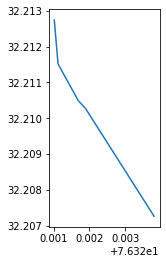

In [22]:
line_gdf.plot()

In [23]:
line_gdf.head()

,node_start,node_end,length,travel_time,line
0,2045041322,2041701267,140,17,"LINESTRING (76.32112 32.21152, 76.32102 32.21277)"
1,2041701267,560454894,126,18,"LINESTRING (76.32169 32.21049, 76.32112 32.21152)"
2,560454894,3067019466,30,3,"LINESTRING (76.32189 32.21028, 76.32169 32.21049)"
3,3067019466,560454880,385,35,"LINESTRING (76.32382 32.20724, 76.32189 32.21028)"


In [24]:
df.tail()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
0,0,2045041322,2041701267,76.321018,32.212767,76.321125,32.211518,140,17,POINT (76.32102 32.21277),POINT (76.32112480000001 32.2115177)
1,1,2041701267,560454894,76.321125,32.211518,76.321692,32.210489,126,18,POINT (76.32112 32.21152),POINT (76.32169210000001 32.2104886)
2,2,560454894,3067019466,76.321692,32.210489,76.321888,32.210280,30,3,POINT (76.32169 32.21049),POINT (76.3218882 32.2102804)
3,3,3067019466,560454880,76.321888,32.210280,76.323821,32.207242,385,35,POINT (76.32189 32.21028),POINT (76.3238207 32.207242)


In [0]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node2]

In [27]:
start

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
0,0,2045041322,2041701267,76.321018,32.212767,76.321125,32.211518,140,17,POINT (76.32102 32.21277),POINT (76.32112480000001 32.2115177)


In [28]:
end

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
3,3,3067019466,560454880,76.321888,32.21028,76.323821,32.207242,385,35,POINT (76.32189 32.21028),POINT (76.3238207 32.207242)


In [29]:
px.set_mapbox_access_token("pk.eyJ1IjoiZGFudGUzMTEyIiwiYSI6ImNrYjR1NjN1MjBqYTczMG8ycjJtZHFyY2sifQ.mGykLIWXQFQAyuTxhn8dHQ")
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=14, width=800, height=400)

In [30]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=14)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])



In [31]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=14, width=800, height=600, animation_frame="index",mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [0]:
fig.data